In [13]:
import torch

import torch.nn as nn
import torch.nn.functional as F

In [11]:
x = torch.tensor([1.], requires_grad=True)

with torch.no_grad():
    y = x * 2

b = x**2

b.backward()

print(f'Does b require grad {b.requires_grad}')
print(f'Does y require grad {y.requires_grad}')

print(x.grad) # gradient of b w.r.t x -> 2*x = 2*1 =2

Does b require grad True
Does y require grad False
tensor([2.])


In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # an affine operation: y = Wx+b
        self.fc1 = nn.Linear(16*6*6, 120) # 6x6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # define the forward function and backward is defined automatically
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # if the size is a square you can specify 1 nb
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [21]:
# get learnable parameters
params = list(net.parameters())
print(len(params))

print(params[0].size()) # conv1's weight

10
torch.Size([6, 1, 3, 3])


In [22]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1042,  0.1048, -0.0611,  0.1059, -0.1301,  0.0098,  0.0547, -0.0952,
          0.1212,  0.0947]], grad_fn=<AddmmBackward>)


In [23]:
# zero the gradient buffers of all parameters and backprop with random gradients
net.zero_grad()
out.backward(torch.randn(1, 10))

In [38]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3732, grad_fn=<MseLossBackward>)


In [39]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [40]:
# need to clear existing gradients else gradients will be accumulated to existing gradients
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0042, -0.0124, -0.0211, -0.0024, -0.0222,  0.0101])


In [41]:
import torchvision
import torchvision.transforms as transforms
# --------- TRAINING A CLASSIFIER --------------------
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

|          | 0/? [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


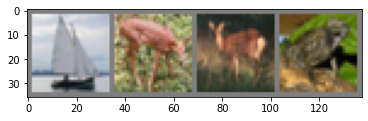

 ship  deer  deer  frog


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + .5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [46]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.194
[1,  4000] loss: 1.213
[1,  6000] loss: 1.193
[1,  8000] loss: 1.159
[1, 10000] loss: 1.167
[1, 12000] loss: 1.167
[2,  2000] loss: 1.092
[2,  4000] loss: 1.097
[2,  6000] loss: 1.116
[2,  8000] loss: 1.093
[2, 10000] loss: 1.087
[2, 12000] loss: 1.076


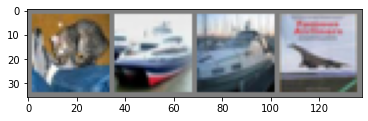

GroundTruth:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 62 %


In [47]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [64]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 77 %
Accuracy of  bird : 54 %
Accuracy of   cat : 40 %
Accuracy of  deer : 54 %
Accuracy of   dog : 57 %
Accuracy of  frog : 68 %
Accuracy of horse : 55 %
Accuracy of  ship : 79 %
Accuracy of truck : 70 %


In [62]:
x = torch.zeros(2, 1, 2, 1, 2)
x[2].item()

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [65]:
# -*- coding: utf-8 -*-
import numpy as np
import math

# Create random input and output data
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# Randomly initialize weights
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

99 1112.6453269350227
199 755.544708535617
299 514.4951701739467
399 351.6209509056397
499 241.45758902723406
599 166.86926767705972
699 116.31444250579312
799 82.01231660351112
899 58.71243254761993
999 42.86833482796224
1099 32.08214548074928
1199 24.730914732372458
1299 19.71503407836162
1399 16.288682007117217
1499 13.945447104831928
1599 12.341097652671861
1699 11.241381710762944
1799 10.486709346642092
1899 9.968232227521208
1999 9.611625342687237
Result: y = 0.023858728086288455 + 0.8731915826289087 x + -0.004116027605833785 x^2 + -0.09567036348801487 x^3


In [66]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

In [70]:
xx[0].shape

torch.Size([3])

In [75]:
# pytorch provides methods to create random or zero-filled tensors -> used to create our weights
# and bias for a simple linear model

#We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).
import math
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [77]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)